## Nonlinear models in sklearn



Nonlinear models have parameters that the output is not linear in. `sklearn` does not provide general nonlinear model fitting routine. That is more commonly a normal regression problem.

We will instead focus on two types of nonlinear models: neural networks and Gaussian Process Regression. These are two different styles of model, with different pros and cons.

Nonlinear models are harder to fit, harder to interpret, and more complex than linear models. You should think hard about whether a nonlinear model is the right next step forward. Some alternatives include using better features with linear models.



## Neural networks



Neural networks are very old in concept. Originally the started as an approach to model neurons in an attempt to build programs that could simulate a brain. This did not work. Since then, we have come to understand much more about what these models are, and how they are related to other models.

[https://scikit-learn.org/stable/modules/neural_networks_supervised.html](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)

Let's dive in and see an example straight away. I do not emphasize the importance of train-test splitting of the data in this example, but it is still an important thing to consider in real applications. We will use the same data you used before from last class. You should run this block several times to see what happens.



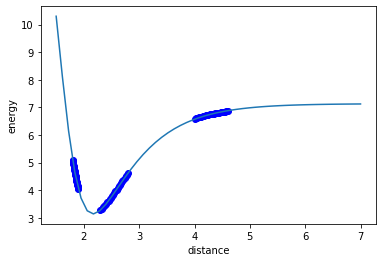

In [1]:
import numpy as np
import json

import matplotlib.pyplot as plt

with open('../07-intermediate-sklearn/data.json') as f:
    data = json.load(f)

X = np.array([data['distance']]).T
y = data['energy']

from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(3,), activation='tanh', solver='lbfgs')
model.fit(X, y)

dfit = np.linspace(1.5, 7)

plt.plot(data['distance'], data['energy'], 'bo',
         dfit, model.predict(dfit[:, None]))

plt.xlabel('distance')
plt.ylabel('energy');

Some notes:

1.  Not every fit is successful. When I run this several times, some work, and some don't.
2.  There are *many* hyperparameters we have to consider. The defaults did not work.
    1.  These hyperparameters include regularization, the optimizer algorithm, and their parameters.
3.  It looks like we really learned the data here. We did not.
    1.  We do see a plateau at large *d* here, but that is a feature of the `tanh` function which has that behavior. Other functions do not do that.
    2.  We actually see the same plateau at negative values of *d* for the same reason.
    3.  You can see what we did was "find" a non-linear function that matches the curvature of our data where have it. There are an *infinite* number of these functions.



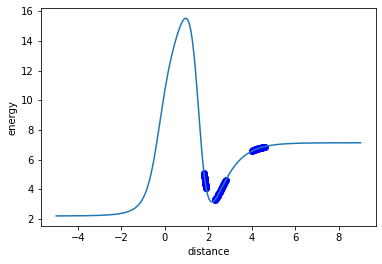

In [1]:
dfit = np.linspace(-5, 9, 200)
plt.plot(data['distance'], data['energy'], 'bo',
         dfit, model.predict(dfit[:, None]))

plt.xlabel('distance')
plt.ylabel('energy');

Let's take a look under the hood here to see what is happening.



In [1]:
model

MLPRegressor(activation='tanh', hidden_layer_sizes=(3,), solver='lbfgs')

Here are the weights for our network.



In [1]:
model.coefs_

| array | (((-1.78587813 0.68207687 2.35072063))) | array | (((-4.37147288) (9.09273804) (-10.9995661))) |

These are the "biases" in the neural network.



In [1]:
model.intercepts_

| array | ((-0.488451 -1.00774886 -3.62964853)) | array | ((4.66936827)) |

We can reconstruct this simple NN in just a few lines of code. I am doing this here to demystify what a neural network is. It is *just* math.



| <matplotlib.lines.Line2D | at | 0x7fb848413640> | <matplotlib.lines.Line2D | at | 0x7fb848413610> |

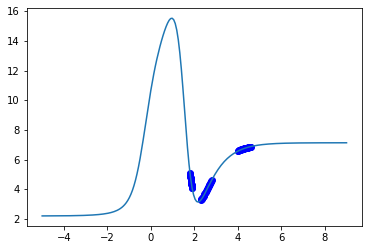

In [1]:
w0, w1 = model.coefs_
b0, b1 = model.intercepts_
#np.tanh(w * X) + b
fit = np.tanh(dfit[:, None] @ w0 + b0) @ w1 + b1

plt.plot(X, y, 'bo', dfit, fit)

It should be evident that this NN is just a small nonlinear model, with 10 free parameters. It might not be a surprise then that it has a lot of flexibility to fit arbitrary data.

The simple linear algebra formulation hides a way to think about this simple model. It is like a truncated (three term) expansion of a function in a `tanh` basis function set. If instead of using tanh, we used `sin` and `cos` functions, we would call this a truncated Fourier series expansion. We have to be a little liberal in this interpretation. In the expansions, the coefficients are well-defined as integrals that are practically projections of the unknown function on the basis function. Here, we treat them as fitting coefficients.

You can choose from dozens of activation functions (not all of them are available in sklearn though). Probably any nonlinear function will work. How to choose them is the subject of a lot of study. The classic functions are `tanh` and `sigmoid`. These are good functions, but they tend to saturate for large magnitude inputs, which makes fitting slow. It is therefore essential to scale the data before fitting so that it all fits in the "active regions" which is roughly between x=-2 and x=2.



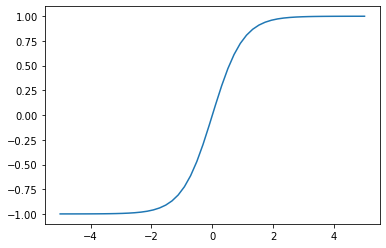

In [1]:
x = np.linspace(-5, 5)
plt.plot(x, np.tanh(x));

A newer function is called ReLU, which is a piece wise linear function. This function does not saturate, but for negative inputs, the function is zero and its derivative is zero. Neurons that get negative values are called "dead" neurons because they don't contribute to the output.

The activation function is the feature that provides the extrapolative behavior of these models. If you don't do extrapolation, it is not that important, but it also can affect how easy the fitting works. The more like your data the activation function is, the better it will be able to fit the data. This is similar to how expansions work.

`sklearn` is good for standard models, and it covers a lot of territory. It is not that great when you stray from the standard territory though. It is just not that easy to extend to new models.

The main choices we have to make are:

1.  The number of nodes in each layer
2.  The number of layers
3.  The activation function
4.  What kind of regularization to use
5.  Which optimizer and its tuning parameters
6.  How to standardize the data input, and what data input to use

These are all hyperparameters that require careful study and analysis to learn how to make the right decisions. There are no simple answers, and the choices are often different for different cases.

Neural networks are frequently criticized for not being "interpretable". This means the parameters typically have no physical meaning, and it is not easy to see how the input is related to the output. This is not much worse than polynomial models though, where the parameters only have as much meaning as the input features provide.



## Gaussian Process Regression



In sklearn: [https://scikit-learn.org/stable/modules/gaussian_process.html](https://scikit-learn.org/stable/modules/gaussian_process.html)

So far, we have considered models where conceptually we get a set of parameters that represent the "best" curve that fits the data. These are called *parametric* models. We can see from the neural network discussion above though that there could be an infinite number of curves that effectively fit the data well. In the so-called Bayesian perspective on this, we could consider a *distribution* of functions then, instead of a single function. Then, instead of a single prediction value, we will get a distribution of predicted values from the distribution of functions. These models are called *non-parametric*, because they don't have fitting parameters in the same sense, they only have hyperparameters that affect the distribution of functions.

The approach we will consider here is called [Gaussian process regression](http://www.gaussianprocess.org/gpml/). We will take a practical perspective with an emphasis on using it, rather than a deep understanding of the theoretical foundations. You can find all of that in this [book](http://www.gaussianprocess.org/gpml/).

The core idea in GPR is that if we have some data that represents a function we can predict new values by computing a similarity metric between the new inputs and the known inputs, and use those to compute a weighted sum of known outputs as a prediction for the new output.

The similarity metric is computed with a *kernel*, and similar to the neural network activation function  we have to choose what kernel to use. The classic kernel is a Gaussian function, also called a radial basis function kernel.



### An example



Our goal is to fit to a function representing the results of the experiments done by Hoffman and Rehage *(Rheological properties of viscoelastic surfactant systems. The Journal of Physical Chemistry, 92(16):4712–4719, 1988.)* to calculate the zero shear viscosity of a worm-like micelles solution. These notes were prepared by Siddhant Lambor.

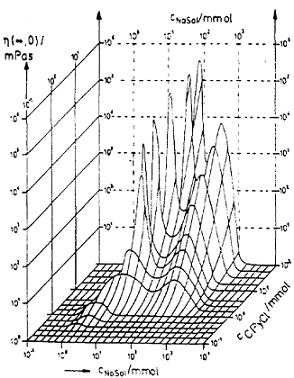

We will be using experimental data which was gathered through gaussian process regression based design of experiments to replicate the above plot.



In [1]:
import pandas as pd
df = pd.read_csv('logzsv.csv', index_col=0)
df

|         |   conc |        zsv | log-conc |  log-zsv |
|---------+--------+------------+----------+----------|
| ExptNo. |        |            |          |          |
|       1 |   1.80 |   1.343571 | 0.587787 | 0.295331 |
|       2 |   7.50 | 470.248800 | 2.014903 | 6.153262 |
|       3 |  31.60 |   4.892228 | 3.453157 | 1.587648 |
|       4 | 133.40 |   9.687286 | 4.893352 | 2.270814 |
|       5 | 562.30 |   1.586862 | 6.332036 | 0.461759 |
|       6 |   3.16 |   1.385140 | 1.150572 | 0.325801 |
|       7 |   5.21 |   4.537974 | 1.650580 | 1.512481 |
|       8 |  11.02 |  57.865808 | 2.399712 | 4.058127 |
|       9 |  18.17 |   8.042775 | 2.899772 | 2.084774 |
|      10 |  60.34 |   7.768176 | 4.099995 | 2.050035 |
|      11 |   4.06 |   1.544971 | 1.401183 | 0.435005 |
|      12 |   8.05 | 537.217396 | 2.085672 | 6.286403 |
|      13 |  23.34 |   5.851642 | 3.150169 | 1.766722 |
|      14 |  94.63 |  11.911588 | 4.549975 | 2.477512 |
|      15 | 295.89 |   3.646146 | 5.689988 | 1.2

Let's take a look at the data. You can see it resembles the figure from the paper. Our goal is to build a model that fits this data, so we can predict values between the data points. This data is clearly not linear in the feature space, and it is not obvious what functional form would fit this data well. A conventional model might be a sum of two Gaussian functions, but we take a different approach here with GPR.



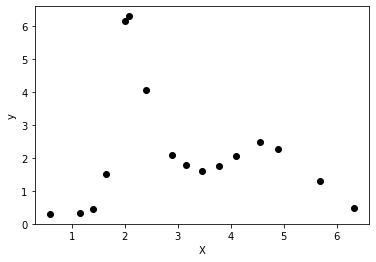

In [1]:
X = np.array(df['log-conc'])[:, None]
y = np.array(df['log-zsv'])[:, None]

plt.plot(X, y, 'ko', label='Training Data')
plt.xlabel('X')
plt.ylabel('y');

As with other `sklearn` models, we can simply import the library. We do that here, and look at the options.



In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
?GaussianProcessRegressor

We also need to import the kernel function. We use a standard Gaussian kernel, known here as a Radial Basis Function, or RBF.



In [1]:
from sklearn.gaussian_process.kernels import RBF
?RBF

We start here with an initial guess for the required hyperparameters. We also look at the "settable" parameters.



In [1]:
kernel = RBF()
gp = GaussianProcessRegressor(alpha=1e-1, kernel=kernel)
gp.get_params()

| alpha | : | 0.1 | copy_X_train | : | True | kernel__length_scale | : | 1.0 | kernel__length_scale_bounds | : | (1e-05 100000.0) | kernel | : | RBF | (length_scale=1) | n_restarts_optimizer | : | 0 | normalize_y | : | False | optimizer | : | fmin_l_bfgs_b | random_state | : | hline |

We use the standard `sklearn` fit function to train this model.



In [1]:
gp = gp.fit(X, y)
print('Optimized kernel parameters:',gp.kernel_.get_params())

Optimized kernel parameters: {'length_scale': 9.999999999999997e-06, 'length_scale_bounds': (1e-05, 100000.0)}
/Users/jkitchin/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "

Next, we examine how well this model worked. *Unlike* other models, this model also provides an estimate of the uncertainty on the predictions.



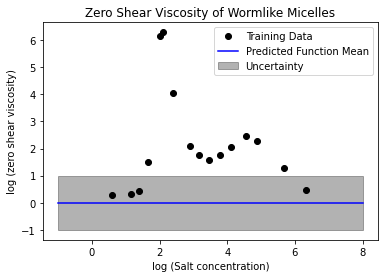

In [1]:
# Test data
x1 = np.linspace(-1, 8)
y1, y1std = gp.predict(x1[:, np.newaxis], return_std=True)

plt.plot(X, y, 'ko', label = 'Training Data')
plt.plot(x1, y1, 'b-', label = "Predicted Function Mean")
plt.title("Zero Shear Viscosity of Wormlike Micelles")
plt.xlabel('X')
plt.ylabel('y')

# Plotting the uncertainty
y1 = y1.flatten()
plt.fill_between(x1, y1 - y1std, y1 + y1std, alpha=0.3, color='k', label="Uncertainty")

plt.xlabel("log (Salt concentration)")
plt.ylabel("log (zero shear viscosity)")
plt.legend();

This model does not work well. We need to work on the model hyperparameters.

Let us look at the parameters of the RBF kernel. We have an argument called 'lengthscale' and length\_scale\_bounds.

Lengthscale is basically the length of the smallest wiggle in the function. It tells us, beyond what distance would two points not be correlated. Thus, we won’t be able to efficiently extrapolate beyond one lengthscale outside the data set. scikit-learn optimizes the lengthscale when we use .fit() within the length\_scale\_bounds. The default bounds of 1e-5 to 1e5 are too wide for our data set.

We can guide the optimization of the model by setting stricter bounds on the lengthscale. Let us go with 0.1 to 1.



In [1]:
kernel = RBF(length_scale_bounds = (0.1, 1.0))

gp = GaussianProcessRegressor(alpha = 0.1, kernel = kernel)

gp = gp.fit(X, y)

print('Optimized kernel parameters:',gp.kernel_.get_params())

Optimized kernel parameters: {'length_scale': 0.3475165861659721, 'length_scale_bounds': (0.1, 1.0)}

Now, we can re-evaluate the fit.



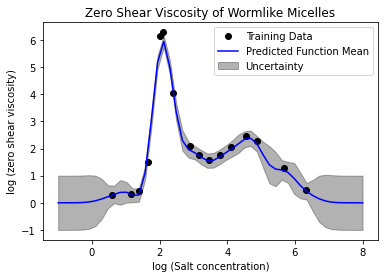

In [1]:
x1 = np.linspace(-1, 8)
y1, y1std = gp.predict(x1[:, np.newaxis], return_std=True)

plt.plot(X, y, 'ko', label = 'Training Data')
plt.plot(x1, y1, 'b-', label = "Predicted Function Mean")
plt.title("Zero Shear Viscosity of Wormlike Micelles")
plt.xlabel('X')
plt.ylabel('y')

# Plotting the uncertainty
y1 = y1.flatten()
plt.fill_between(x1, y1 - y1std, y1 + y1std, alpha=0.3, color='k', label = "Uncertainty")

plt.xlabel("log (Salt concentration)")
plt.ylabel("log (zero shear viscosity)")
plt.legend();

As we can see now, this is a much better model. With the uncertainty regions along the function, we would know which areas would require more data and can target gathering data (in this case through experiments) only in the regions of high uncertainty. The final acceptable uncertainty in the model is upto the user to decide.

Over here we have chosen the bounds (0.1 to 1.0) based on some domain insight and hyperparameter optimization using log marginal likelihood. The actual mechanics behind LML might require a deeper dive into Bayesian approaches in ML.

Let's consider extrapolation. GP is not a magic bullet either. Once you get far from your known data, the correlation with known data decays to zero, and the model extrapolates like the kernel function. Since the Gaussian function has not physics in it, this model does not extrapolate with physical meaning.



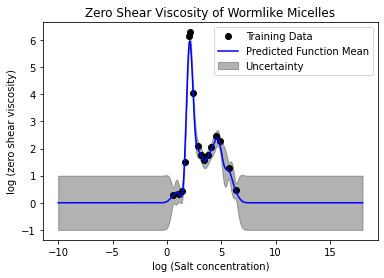

In [1]:
x1 = np.linspace(-10, 18, 1500)
y1, y1std = gp.predict(x1[:, np.newaxis], return_std=True)

plt.plot(X, y, 'ko', label = 'Training Data')
plt.plot(x1, y1, 'b-', label = "Predicted Function Mean")
plt.title("Zero Shear Viscosity of Wormlike Micelles")
plt.xlabel('X')
plt.ylabel('y')

# Plotting the uncertainty
y1 = y1.flatten()
plt.fill_between(x1, y1 - y1std, y1 + y1std, alpha=0.3, color='k', label = "Uncertainty")

plt.xlabel("log (Salt concentration)")
plt.ylabel("log (zero shear viscosity)")
plt.legend();

The RBF is a generic kernel that always works when you have enough data. It is similar to using tanh in a neural network, which also always works when you have enough data.

GPR and neural networks are related conceptually. You can think of the GP as an expansion of the data in an *infinite* set of basis functions. Nns, in contrast, are like an expansion in a *finite* basis set. In the limit of an infinitely wide NN, i.e. if you could have an infinite number of neurons in a layer, it is basically equivalent to a GP. OF course, we cannot compute an infinitely wide NN, and the GP is only possible because there is clever math that converts the infinite sum to an equivalent finite sum, this is called the "kernel trick".

There are some critical differences between GP and neural networks though. While neural networks have parameters, in the form of weights and biases, a GP only has hyperparameters in the form of things like the lengthscale of correlation.

The cost of evaluating a NN is a constant and does not depend on the size of the training data. In contrast, the cost of evaluating a GP *depends* on the size of the training data because you have to compute the correlation between the new point and *all* of the existing points. This can be expensive for large data sets.

Many people like GP because it comes with an estimate of the uncertainty in the prediction. You should take this with some care, it is the uncertainty associated with an imperfect and assumed correlation between data points. If you have a very poor kernel, the uncertainty may not be useful.

Neural networks do not have an easy way to estimate uncertainty. There are some approaches to doing it, also based on some assumptions, but most require access to the second derivative of the training function with respect to the model parameters, which can be expensive to compute. It is not common to see uncertainty estimates for neural networks yet.



## Summary



This was a brief introduction to two styles of nonlinear modeling in `sklearn`. There are many, more powerful things that you can do with them, including using multi-dimensional inputs, adding regularization, kernel engineering, etc.

There is not much on neural networks for regression in sklearn, but there are some examples at [https://scikit-learn.org/stable/auto_examples/index.html#neural-networks>](https://scikit-learn.org/stable/auto_examples/index.html#neural-networks>)on classification.

For more examples on Gaussian process in sklearn see [https://scikit-learn.org/stable/auto_examples/index.html#gaussian-process-for-machine-learning](https://scikit-learn.org/stable/auto_examples/index.html#gaussian-process-for-machine-learning).

There are many other algorithms available for regression in sklearn: [https://scikit-learn.org/stable/supervised_learning.html](https://scikit-learn.org/stable/supervised_learning.html)

You should be wary of approaches that try all these and then report the best one. In principle, many can work equally well with enough data. Unless you can explain why an approach is mathematically better suited for a data set, odds are the better fit is due to luck and/or overfitting. Neither of these is helpful when you want to make reliable predictions!

